In [ ]:
import json
import os
import shutil
import time

import pandas as pd
import numpy as np
import pathlib
import geopandas as gpd
import pysal as ps

from sklearn import cluster
from sklearn.preprocessing import scale

# Entrada e pre-processamento de dados
app_path = pathlib.Path(__file__).parent.resolve()
data_path = pathlib.Path(__file__).parent.joinpath("data")
geo_json_path = data_path.joinpath("Zipcodes.geojson")
austin_listings = pd.read_csv(data_path.joinpath("listings.csv"), low_memory=False)

# Refractor zipcode outlier, modify in place
zip_outlier = austin_listings[austin_listings["zipcode"] == "TX 78702"].index
austin_listings.loc[zip_outlier, "zipcode"] = "78702"
austin_listings = austin_listings.dropna(axis=0, subset=["zipcode"])

review_columns = [c for c in austin_listings.columns if "review_" in c]

# Geojson loading
with open(geo_json_path) as response:
    zc_link = json.load(response)
    # Add id for choropleth layer
    for feature in zc_link["features"]:
        feature["id"] = feature["properties"]["zipcode"]

listing_zipcode = austin_listings["zipcode"].unique()

In [ ]:
def apply_clustering():
    """
     # Apply KMeans clustering to group zipcodes into categories based on type of houses listed(i.e. property type)
    :return: Dataframe.
    db: scaled proportions of house types by zipcode, use for plotting Choropleth map layer.
    barh_df : scaled proportion of house type grouped by cluster, use for prop type chart and review chart.
    """
    variables = ["bedrooms", "bathrooms", "beds"]
    aves = austin_listings.groupby("zipcode")[variables].mean()
    review_aves = austin_listings.groupby("zipcode")[review_columns].mean()

    types = pd.get_dummies(austin_listings["property_type"])
    prop_types = types.join(austin_listings["zipcode"]).groupby("zipcode").sum()
    prop_types_pct = (prop_types * 100.0).div(prop_types.sum(axis=1), axis=0)

    aves_props = aves.join(prop_types_pct)

    # Standardize a dataset along any axis, Center to the mean and component wise scale to unit variance.
    db = pd.DataFrame(
        scale(aves_props), index=aves_props.index, columns=aves_props.columns
    ).rename(lambda x: str(x))

    # Apply clustering on scaled df
    km5 = cluster.KMeans(n_clusters=5)
    km5cls = km5.fit(db.reset_index().values)
    # print(len(km5cls.labels_))

    db["cl"] = km5cls.labels_

    # sort by labels since every time cluster is running, label 0-4 is randomly assigned
    db["count"] = db.groupby("cl")["cl"].transform("count")

    db.sort_values("count", inplace=True, ascending=True)

    barh_df = prop_types_pct.assign(cl=km5cls.labels_).groupby("cl").mean()

    # Join avg review columns for updating review plot
    db = db.join(review_aves)
    grouped = db.groupby("cl")[review_columns].mean()
    barh_df = barh_df.join(grouped)

    return db.reset_index(), barh_df


In [ ]:
def rating_clustering(threshold):
    start = time.time()
    # Explore boundaries/ areas where customers are have similar ratings. Different from
    # predefined number of output regions, it takes target variable(num of reviews, and
    # apply a minimum threshold (5% per region) on it.

    # Bring review columns at zipcode level
    rt_av = austin_listings.groupby("zipcode")[review_columns].mean().dropna()

    # Regionalization requires building of spatial weights
    zc = gpd.read_file(geo_json_path)
    zrt = zc[["geometry", "zipcode"]].join(rt_av, on="zipcode").dropna()
    zrt.to_file("tmp")
    w = ps.queen_from_shapefile("tmp/tmp.shp", idVariable="zipcode")

    # Remove temp tmp/* we created for spatial weights
    if os.path.isdir(os.path.join(app_path, "tmp")):
        print("removing tmp folder")
        shutil.rmtree(os.path.join(app_path, "tmp"))

    # Impose that every resulting region has at least 5% of the total number of reviews
    n_review = (
        austin_listings.groupby("zipcode")
        .sum()["number_of_reviews"]
        .rename(lambda x: str(int(x)))
        .reindex(zrt["zipcode"])
    )
    thr = np.round(int(threshold) / 100 * n_review.sum())

    # Set the seed for reproducibility
    np.random.seed(1234)

    z = zrt.drop(["geometry", "zipcode"], axis=1).values
    # Create max-p algorithm, note that this API is upgraded in pysal>1.11.1
    maxp = ps.region.Maxp(w, z, thr, n_review.values[:, None], initial=100)
    maxp.cinference(nperm=99)
    # p value compared with randomly assigned region
    p_value = maxp.cpvalue
    print("p_value:", p_value)
    lbls = pd.Series(maxp.area2region).reindex(zrt["zipcode"])
    regionalization_df = (
        pd.DataFrame(lbls).reset_index().rename(columns={"zipcode": "zipcode", 0: "cl"})
    )

    end = time.time()
    # The larger threshold, the longer time it takes for computing
    print(
        "Computing threshold {}%".format(threshold),
        "time cost for clustering: ",
        end - start,
    )

    types = pd.get_dummies(austin_listings["property_type"])
    prop_types = types.join(austin_listings["zipcode"]).groupby("zipcode").sum()
    merged = pd.merge(
        prop_types.reset_index(), regionalization_df, on="zipcode", how="inner"
    )
    d_merged = merged.drop(["zipcode", "cl"], axis=1)
    prop_types_pct = (d_merged * 100.0).div(d_merged.sum(axis=1), axis=0)

    pct_d = (
        prop_types_pct.assign(cl=merged["cl"], zipcode=merged["zipcode"])
        .groupby("cl")
        .mean()
    )

    zrt = zrt[review_columns].groupby(lbls.values).mean()
    joined_prop = pct_d.join(zrt)
    return regionalization_df, p_value, joined_prop

In [ ]:
  
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd

from helpers import (
    austin_listings,
    zc_link,
    apply_clustering,
    rating_clustering,
    review_columns,
)

app = dash.Dash(__name__)
server = app.server
app.config.suppress_callback_exceptions = True

# CONSTANTS
grouped = austin_listings.groupby("zipcode").size()

mapbox_token = "pk.eyJ1IjoicGxvdGx5bWFwYm94IiwiYSI6ImNrOWJqb2F4djBnMjEzbG50amg0dnJieG4ifQ.Zme1-Uzoi75IaFbieBDl3A"

geo_colors = [
    "#8dd3c7",
    "#ffd15f",
    "#bebada",
    "#fb8072",
    "#80b1d3",
    "#fdb462",
    "#b3de69",
    "#fccde5",
    "#d9d9d9",
    "#bc80bd",
    "#ccebc5",
]

bar_coloway = [
    "#fa4f56",
    "#8dd3c7",
    "#ffffb3",
    "#bebada",
    "#80b1d3",
    "#fdb462",
    "#b3de69",
    "#fccde5",
    "#d9d9d9",
    "#bc80bd",
    "#ccebc5",
    "#ffed6f",
]

intro_text = """
**About this app**
This app applies spatial clustering and regionalization analysis to discover the [dataset of AirBnb listings in the
city of Austin](http://insideairbnb.com/get-the-data.html). Models are created using [pysal](https://pysal.readthedocs.io/en/latest/)
and scikit-learn.
Select the type of model from radioitem, click on the button to run clustering and visualize output regions geographically on the map, computing may take seconds to finish. Click
on regions on the map to update the number of airbnb listings from your highlighted group.
"""

listing_txt = """
out of *{}* total listings
""".format(
    grouped.sum()
)

INIT_THRESHOLD_VAL = 5


def header_section():
    return html.Div(
        [
            html.Img(src=app.get_asset_url("dash-logo.png"), className="logo"),
            html.H4("Spatial Clustering"),
        ],
        className="header__title",
    )


def make_base_map():
    # Scattermapbox with geojson layer, plot all listings on mapbox
    customdata = list(
        zip(
            austin_listings["host_name"],
            austin_listings["name"],
            austin_listings["host_since"],
            austin_listings["price"],
            austin_listings["accommodates"],
            austin_listings["availability_365"],
            round(austin_listings["availability_365"] / 365 * 100, 1),
        )
    )
    mapbox_figure = dict(
        type="scattermapbox",
        lat=austin_listings["latitude"],
        lon=austin_listings["longitude"],
        marker=dict(size=7, opacity=0.7, color="#550100"),
        customdata=customdata,
        name="Listings",
        hovertemplate="<b>Host: %{customdata[0]}</b><br><br>"
        "<b>%{customdata[1]}</b><br>"
        "<b>Host Since: </b>%{customdata[2]}<br>"
        "<b>Price: </b>%{customdata[3]} / night<br>"
        "<b>Person to accommodate: </b>%{customdata[4]}<br>"
        "<b>Yearly Availability: </b>%{customdata[5]} days/year (%{customdata[6]} %)",
    )

    layout = dict(
        mapbox=dict(
            style="streets",
            uirevision=True,
            accesstoken=mapbox_token,
            zoom=9,
            center=dict(
                lon=austin_listings["longitude"].mean(),
                lat=austin_listings["latitude"].mean(),
            ),
        ),
        shapes=[
            {
                "type": "rect",
                "xref": "paper",
                "yref": "paper",
                "x0": 0,
                "y0": 0,
                "x1": 1,
                "y1": 1,
                "line": {"width": 1, "color": "#B0BEC5"},
            }
        ],
        margin=dict(l=10, t=10, b=10, r=10),
        height=900,
        showlegend=True,
        hovermode="closest",
    )

    figure = {"data": [mapbox_figure], "layout": layout}
    return figure


def make_map_with_clustering(sel_ind, c_type, stored_data):
    """
    Update layers on map from clustering regions.
    :param sel_ind: lasso-select index from map.selectedData.
    :param c_type: cluster type.
    :param stored_data: datastore from computing.
    :return: Plotly figure object.
    """
    # Group based on zipcode
    figure = make_base_map()

    # Decrease opacity of scatter
    figure["data"][0]["marker"].update(opacity=0.02)
    figure["layout"].update(
        dragmode="lasso"
    )  # clickmode doesn't work but drag will select scatters

    db = pd.DataFrame()
    if c_type == "ht-cluster":
        db = pd.read_json(stored_data["ht"]["data"])
    elif c_type == "rating-cluster":
        db, p_val = pd.read_json(stored_data["rt"]["data"]), stored_data["rt"]["p_val"]

    for ind, i in enumerate(db["cl"].unique()):
        # Choro cluster by zipcode, split into different colored choro layer after clustering or regionalization.
        figure["data"].append(
            dict(
                type="choroplethmapbox",
                showlegend=True,
                geojson=zc_link,
                locations=db[db["cl"] == i]["zipcode"],
                z=list(1 for _ in range(len(db[db["cl"] == i]["zipcode"]))),
                hoverinfo="location",
                name="Group {}".format(ind + 1),
                customdata=list(ind for _ in range(len(db[db["cl"] == i]["zipcode"]))),
                selected=dict(marker=dict(opacity=1)),
                unselected=dict(marker=dict(opacity=0.2)),
                selectedpoints="" if ind == sel_ind or sel_ind is None else [],
                marker=dict(opacity=0.8, line=dict(width=1)),
                colorscale=[[0, geo_colors[ind]], [1, geo_colors[ind]]],
                showscale=False,
            )
        )

    # move scatter trace at the end and disable its hover effect
    figure["data"].append(figure["data"].pop(0))
    figure["data"][-1].update(dict(hoverinfo="skip", hovertemplate=""))

    return figure


def make_original_property_graph():
    # Property type without any grouping
    types = pd.get_dummies(austin_listings["property_type"])
    prop_types = types.join(austin_listings["zipcode"]).groupby("zipcode").sum()
    prop_types_pct = (prop_types * 100.0).div(prop_types.sum(axis=1), axis=0)

    # Plot horizontal bars
    bar_fig = []

    for prop in list(prop_types_pct.columns):
        bar_fig.append(
            go.Bar(
                name=prop,
                orientation="h",
                y=[str(i) for i in prop_types_pct.index],
                x=prop_types_pct[prop],
            )
        )
    figure = go.Figure(
        data=bar_fig,
        layout=dict(
            barmode="stack",
            colorway=bar_coloway,
            yaxis_type="category",
            margin=dict(l=10, r=10, t=10, b=10),
            showlegend=False,
            height=1000,
            yaxis=dict(title="ZipCode"),
            paper_bgcolor="rgba(0,0,0,0)",
            plot_bgcolor="rgba(0,0,0,0)",
        ),
    )
    return figure


def make_property_graph(pct: pd.DataFrame) -> dict:
    # Demographic explore patterns clustering results
    bar_fig = []
    for prop in pct.columns:
        bar_fig.append(
            go.Bar(
                name=prop,
                x=["Group {}".format(int(i) + 1) for i in pct.index],
                y=pct[prop],
                marker=dict(opacity=0.8, line=dict(color="#ddd")),
                orientation="v",
            )
        )

    fig = go.Figure(
        data=bar_fig,
        layout=dict(
            barmode="stack",
            colorway=bar_coloway,
            margin=dict(l=10, r=10, t=10, b=10),
            legend=dict(traceorder="reversed", font=dict(size=9)),
            height=400,
            paper_bgcolor="rgba(0,0,0,0)",
            plot_bgcolor="rgba(0,0,0,0)",
        ),
    )

    return fig


def make_review_chart(pct_d, original=False):
    fig = []
    for ind, rows in pct_d.iterrows():
        fig.append(
            go.Scatter(
                x=[x.split("_")[-1].capitalize() for x in review_columns],
                y=rows,
                name="Group {}".format(ind + 1) if not original else "All listings",
                mode="markers+lines",
                hovertemplate="<b> Review Score %{x}: </b> %{y}",
                marker=dict(
                    size=12,
                    opacity=0.8,
                    color=geo_colors[ind],
                    line=dict(width=1, color="#ffffff"),
                ),
            )
        )
    return {
        "data": fig,
        "layout": dict(
            yaxis=dict(title="Scores"),
            margin=dict(l=40, r=10, t=10, b=70),
            hovermode="closest",
        ),
    }


def populate_init_data():
    # Initialize data store with default computing
    ht_res = apply_clustering()
    rt_res = rating_clustering(INIT_THRESHOLD_VAL)
    return {
        "ht": {"data": ht_res[0].to_json(), "pct": ht_res[1].to_json()},
        "rt": {
            "data": rt_res[0].to_json(),
            "p_val": rt_res[1],
            "pct_d": rt_res[2].to_json(),
        },
    }


# Dash App Layout
app.layout = html.Div(
    children=[
        dcc.Store(id="cluster-data-store", data=populate_init_data()),
        # Banner
        header_section(),
        html.Div(
            [
                html.Div(
                    children=[
                        html.Div(id="intro-text", children=dcc.Markdown(intro_text)),
                        html.P("Austin Airbnb listings"),
                        html.Hr(),
                        dcc.Graph(id="map", config={"responsive": True}),
                    ],
                    className="eight columns named-card",
                ),
                # Categorical properties by cluster e.g (property type stacked bar)
                html.Div(
                    children=[
                        html.P("Map Options"),
                        html.Hr(),
                        dcc.RadioItems(
                            id="cluster-ctl",
                            options=[
                                {"label": "All Listings", "value": "no-cluster"},
                                {
                                    "label": "Cluster based on house type",
                                    "value": "ht-cluster",
                                },
                                {
                                    "label": "Regionalization based on Ratings",
                                    "value": "rating-cluster",
                                },
                            ],
                            value="no-cluster",
                        ),
                        html.Div(
                            id="threshold-div",
                            children=[
                                html.P("Minimum Threshold (% of reviews / region)"),
                                dcc.Slider(
                                    id="regionalization-threshold",
                                    min=5,
                                    max=30,
                                    marks={
                                        5: "5%",
                                        10: "10%",
                                        15: "15%",
                                        20: "20%",
                                        25: "25%",
                                        30: "30%",
                                    },
                                    value=INIT_THRESHOLD_VAL,
                                    tooltip={"placement": "bottom"},
                                ),
                            ],
                        ),
                        html.Div(
                            html.Button(
                                "Run Clustering & Update Map",
                                id="btn-updt-map",
                                title="Click to run spatial clustering, computing could take seconds to complete.",
                                n_clicks=0,
                            ),
                            className="btn-outer",
                        ),
                        html.Hr(),
                        html.Div(
                            id="listing-div",
                            children=[
                                html.H6("1000", id="listing-ind"),
                                dcc.Markdown(listing_txt, id="total-listings"),
                            ],
                        ),
                        html.P("Property Types"),
                        html.Hr(),
                        dcc.Graph(id="geodemo-chart"),
                        html.P("User satisfactions"),
                        html.Hr(),
                        dcc.Graph(id="user-satisfaction"),
                    ],
                    className="four columns named-card",
                ),
            ],
            className="twelve columns",
        ),
    ],
    className="container twelve columns",
)


# =====Callbacks=====
@app.callback(
    Output("map", "figure"),
    [Input("map", "clickData"), Input("cluster-data-store", "data")],
    [State("cluster-ctl", "value")],
)
def update_map(region_select, ds, clustering_type):
    # Update map based on selectedData and stored calculation
    ctx = dash.callback_context
    print("cluster type", clustering_type)
    if ds is not None:
        if "ht" in clustering_type or "rating" in clustering_type:
            if ctx.triggered and "data-store" in ctx.triggered[0]["prop_id"]:
                figure = make_map_with_clustering(None, clustering_type, ds)
                return figure
            if region_select is not None:
                # Empty select will return the entire non-selected figure
                if not len(region_select["points"]):
                    return make_map_with_clustering(None, clustering_type, ds)
                else:
                    for point in region_select["points"]:
                        if len(str(point["customdata"])) == 1:
                            print(
                                "selected region: Group {}".format(
                                    point["customdata"] + 1
                                )
                            )
                            return make_map_with_clustering(
                                point["customdata"], clustering_type, ds
                            )
            return make_map_with_clustering(None, clustering_type, ds)
        else:
            return make_base_map()
    return make_base_map()


@app.callback(
    Output("cluster-data-store", "data"),
    [Input("btn-updt-map", "n_clicks")],
    [
        State("cluster-ctl", "value"),
        State("cluster-data-store", "data"),
        State("regionalization-threshold", "value"),
    ],
)
def update_ds(n_clicks, clustering_type, cur_ds, thr):
    # Apply algorithm and only apply computing once upon button=click,save it for figure loading
    if n_clicks:
        if clustering_type == "ht-cluster":
            # Apply KMeans and update datastore
            ht_res = apply_clustering()
            cur_ds.update(ht={"data": ht_res[0].to_json(), "pct": ht_res[1].to_json()})
        elif clustering_type == "rating-cluster":
            rt_res = rating_clustering(thr)
            cur_ds.update(
                rt={
                    "data": rt_res[0].to_json(),
                    "p_val": rt_res[1],
                    "pct_d": rt_res[2].to_json(),
                }
            )
        else:
            return cur_ds
        return cur_ds
    return cur_ds


@app.callback(
    [Output("listing-ind", "children"), Output("listing-ind", "style")],
    [Input("map", "clickData"), Input("btn-updt-map", "n_clicks")],
    [State("cluster-ctl", "value"), State("cluster-data-store", "data")],
)
def update_indicator(map_select, n_click, cluster_type, ds):
    ctx = dash.callback_context
    if ctx.triggered and "clickData" in ctx.triggered[0]["prop_id"]:
        ht = pd.read_json(ds["ht"]["data"])
        rt = pd.read_json(ds["rt"]["data"])
        if cluster_type == "ht-cluster":
            dff = ht
        elif cluster_type == "rating-cluster":
            dff = rt
        if map_select is None:
            return str(len(austin_listings)), {"color": "#550100"}

        else:
            for point in map_select["points"]:
                if len(str(point["customdata"])) == 1:
                    print("selected region: Group {}".format(point["customdata"] + 1))
                    sel_ind = point["customdata"]
                    zips = dff[dff["cl"] == sel_ind]["zipcode"]
                    count = 0
                    for zip in zips:
                        count += grouped[str(zip)]
                    return str(count), {"color": geo_colors[sel_ind]}

    return str(len(austin_listings)), {"color": "#550100"}


@app.callback(
    Output("geodemo-chart", "figure"),
    [Input("cluster-data-store", "data")],
    [State("cluster-ctl", "value")],
)
def update_geodemo_chart(ds, clustering_type):
    # Update upon clustering updates ds
    if ds:
        if clustering_type == "ht-cluster":
            pct = pd.read_json(ds["ht"]["pct"]).drop(review_columns, axis=1)
            return make_property_graph(pct)
        if clustering_type == "rating-cluster":
            pct_d = pd.read_json(ds["rt"]["pct_d"]).drop(review_columns, axis=1)
            return make_property_graph(pct_d)
        elif clustering_type == "no-cluster":
            return make_original_property_graph()
    return make_original_property_graph()


@app.callback(
    Output("user-satisfaction", "figure"),
    [Input("cluster-data-store", "data")],
    [State("cluster-ctl", "value")],
)
def update_review_chart(ds, clustering_type):
    # y: Average score, x: category, color: group
    empty_fig = {
        "data": [],
        "layout": dict(
            yaxis=dict(title="Scores"),
            margin=dict(l=30, r=10, t=10, b=70),
            hovermode="closest",
        ),
    }

    if clustering_type == "rating-cluster":
        pct_d = pd.read_json(ds["rt"]["pct_d"])[review_columns]
        pct_d[review_columns[1:]] = pct_d[review_columns[1:]] * 10
        return make_review_chart(pct_d)
    elif clustering_type == "ht-cluster":
        ht = pd.read_json(ds["ht"]["pct"])[review_columns]
        ht[review_columns[1:]] = ht[review_columns[1:]] * 10
        return make_review_chart(ht)
    elif clustering_type == "no-cluster":
        # Avg review scores for all data
        dff = austin_listings[review_columns].mean(axis=0, skipna=True)
        dff_t = pd.DataFrame(dff).transpose()
        dff_t[review_columns[1:]] = dff_t[review_columns[1:]] * 10
        return make_review_chart(dff_t, original=True)
    return empty_fig


@app.callback(Output("threshold-div", "style"), [Input("cluster-ctl", "value")])
def update_div(clustering_type):
    if clustering_type == "rating-cluster":
        return {"display": "block"}
    return {"display": "none"}


if __name__ == "__main__":
    app.run_server(
        debug=True, port=8051, dev_tools_hot_reload=False, use_reloader=False
    )

## MeanShift
O clustering MeanShift visa descobrir blobs em uma densidade uniforme de amostras. É um algoritmo baseado em centróide, que funciona atualizando candidatos a centróides para serem a média dos pontos dentro de uma determinada região. Esses candidatos são então filtrados em um estágio de pós-processamento para eliminar quase duplicatas e formar o conjunto final de centróides.

Dado um candidato a centróide
 para iteração, o candidato é atualizado de acordo com a seguinte equação:

Onde
 é a vizinhança das amostras dentro de uma determinada distância em torno
 e é o vetor de deslocamento médio que é calculado para cada centróide que aponta para uma região de aumento máximo na densidade de pontos. Isso é calculado usando a seguinte equação, atualizando efetivamente um centróide para ser a média das amostras em sua vizinhança:
 
O algoritmo define automaticamente o número de clusters, em vez de depender de um parâmetro de largura de banda, que determina o tamanho da região a ser pesquisada. Este parâmetro pode ser definido manualmente, mas pode ser estimado usando a função fornecida estimativa_bandwidth, que é chamada se a largura de banda não for definida.

O algoritmo não é altamente escalável, pois requer várias pesquisas de vizinho mais próximo durante a execução do algoritmo. O algoritmo tem garantia de convergência, no entanto, o algoritmo irá parar de iterar quando a mudança nos centróides for pequena.

Numero estimado de clusters : 4


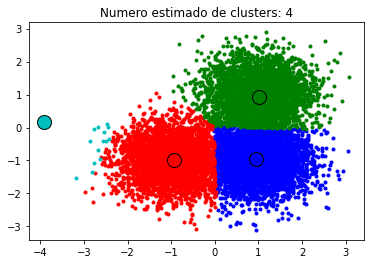

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# #############################################################################
# Dataset de amostra
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# #############################################################################
# Calcular clustering com MeanShift

# Estimacao de largura de banda
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters : %d" % n_clusters_)

# #############################################################################
# Plotar resultados
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

In [ ]:
import pandas as pd
pd.DataFrame(labels)

,0
0,0
1,2
2,1
3,2
4,1
...,...
9995,0
9996,1
9997,1
9998,2


In [ ]:
pd.DataFrame(X)

,0,1
0,0.697493,-0.917772
1,-0.019330,-0.974149
2,0.419923,0.792690
3,-1.478129,-2.004756
4,1.683431,0.175709
...,...,...
9995,1.615834,-1.220058
9996,0.980926,0.140061
9997,0.693242,0.203720
9998,-0.779851,-0.682419


In [ ]:
np.array([[0.69749283, -0.91777192, 'CASA +']]) 

## DBSCAN
O algoritmo DBSCAN vê os clusters como áreas de alta densidade separadas por áreas de baixa densidade. Devido a essa visão um tanto genérica, os clusters encontrados pelo DBSCAN podem ter qualquer formato, ao contrário do k-means, que assume que os clusters têm formato convexo. O componente central do DBSCAN é o conceito de amostras de núcleo, que são amostras que estão em áreas de alta densidade. Um cluster é, portanto, um conjunto de amostras de núcleo, cada uma próxima uma da outra (medida por alguma medida de distância) e um conjunto de amostras não essenciais que estão perto de uma amostra de núcleo (mas não são elas próprias amostras de núcleo). Existem dois parâmetros para o algoritmo, min_samples e eps, que definem formalmente o que queremos dizer quando dizemos denso. Mais min_samples ou eps mais baixos indicam maior densidade necessária para formar um cluster.

Mais formalmente, definimos uma amostra de núcleo como sendo uma amostra no conjunto de dados de forma que existam min_samples outras amostras dentro de uma distância de eps, que são definidas como vizinhas da amostra de núcleo. Isso nos diz que a amostra do núcleo está em uma área densa do espaço vetorial. Um cluster é um conjunto de amostras de núcleo que podem ser construídas tomando recursivamente uma amostra de núcleo, encontrando todos os seus vizinhos que são amostras de núcleo, encontrando todos os seus vizinhos que são amostras de núcleo e assim por diante. Um cluster também tem um conjunto de amostras não essenciais, que são amostras vizinhas de uma amostra principal no cluster, mas não são, elas próprias, amostras principais. Intuitivamente, essas amostras estão à margem de um cluster.

Qualquer amostra central faz parte de um cluster, por definição. Qualquer amostra que não seja uma amostra de núcleo e esteja pelo menos eps em distância de qualquer amostra de núcleo é considerada um outlier pelo algoritmo.

Enquanto o parâmetro min_samples controla principalmente o quão tolerante o algoritmo é em relação ao ruído (em conjuntos de dados grandes e barulhentos, pode ser desejável aumentar este parâmetro), o parâmetro eps é crucial para escolher apropriadamente para o conjunto de dados e função de distância e geralmente não pode ser deixado no valor padrão. Ele controla a vizinhança local dos pontos. Quando escolhido muito pequeno, a maioria dos dados não será agrupada (e rotulada como -1 para “ruído”). Quando escolhido muito grande, ele faz com que os clusters próximos sejam mesclados em um cluster e, eventualmente, todo o conjunto de dados seja retornado como um único cluster. Algumas heurísticas para a escolha deste parâmetro foram discutidas na literatura, por exemplo, com base em um joelho no gráfico de distâncias do vizinho mais próximo (conforme discutido nas referências abaixo).

Na figura abaixo, a cor indica a associação do cluster, com grandes círculos indicando as amostras principais encontradas pelo algoritmo. Círculos menores são amostras não essenciais que ainda fazem parte de um cluster. Além disso, os outliers são indicados por pontos pretos abaixo.
______________________________________________________

### Implementação

O algoritmo DBSCAN é determinístico, gerando sempre os mesmos clusters quando dados os mesmos dados na mesma ordem. No entanto, os resultados podem ser diferentes quando os dados são fornecidos em uma ordem diferente. Primeiro, embora as amostras principais sejam sempre atribuídas aos mesmos clusters, os rótulos desses clusters dependerão da ordem em que essas amostras são encontradas nos dados. Em segundo lugar, e mais importante, os clusters aos quais as amostras não essenciais são designadas podem diferir dependendo da ordem dos dados. Isso aconteceria quando uma amostra não essencial tem uma distância inferior a eps para duas amostras principais em clusters diferentes. Pela desigualdade triangular, essas duas amostras centrais devem estar mais distantes do que eps uma da outra, ou estariam no mesmo cluster. A amostra não principal é atribuída a qualquer cluster gerado primeiro em uma passagem pelos dados e, portanto, os resultados dependerão da ordem dos dados.

Numero estimado de clusters: 3
Numero estimado de pontos ruidosos: 18
Homogeneidade: 0.953
Completeness: 0.883
V-measure: 0.917
Indice aleatorio ajustado: 0.952
Informacao mutual ajustada: 0.916
Coeficientede silueta: 0.626


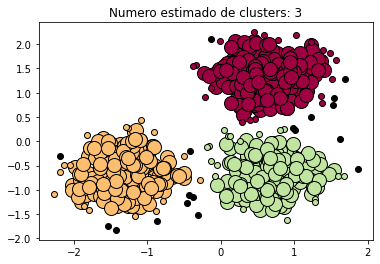

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Dataset de exemplo
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Executar DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Numero de clusters por labels, ignorando ruidos.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Numero estimado de clusters: %d' % n_clusters_)
print('Numero estimado de pontos ruidosos: %d' % n_noise_)
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Indice aleatorio ajustado: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Informacao mutual ajustada: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Coeficientede silueta: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plotar resultados
import matplotlib.pyplot as plt

# Pontos pretossao ruidos
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

## OPTICS
O algoritmo OPTICS compartilha muitas semelhanças com o algoritmo DBSCAN e pode ser considerado uma generalização do DBSCAN que relaxa o requisito de eps de um único valor para um intervalo de valores. A principal diferença entre DBSCAN e OPTICS é que o algoritmo OPTICS constrói um gráfico de alcançabilidade, que atribui a cada amostra uma distância de alcance_ e um ponto dentro do atributo ordering_ de cluster; esses dois atributos são atribuídos quando o modelo é ajustado e são usados ​​para determinar a associação do cluster. Se OPTICS for executado com o valor padrão de inf definido para max_eps, a extração de cluster de estilo DBSCAN pode ser executada repetidamente em tempo linear para qualquer valor eps fornecido usando o método cluster_optics_dbscan. Definir max_eps com um valor inferior resultará em tempos de execução mais curtos e pode ser considerado o raio máximo da vizinhança de cada ponto para encontrar outros pontos potenciais alcançáveis.

The reachability distances generated by OPTICS allow for variable density extraction of clusters within a single data set. As shown in the above plot, combining reachability distances and data set ordering_ produces a reachability plot, where point density is represented on the Y-axis, and points are ordered such that nearby points are adjacent. ‘Cutting’ the reachability plot at a single value produces DBSCAN like results; all points above the ‘cut’ are classified as noise, and each time that there is a break when reading from left to right signifies a new cluster. The default cluster extraction with OPTICS looks at the steep slopes within the graph to find clusters, and the user can define what counts as a steep slope using the parameter xi. There are also other possibilities for analysis on the graph itself, such as generating hierarchical representations of the data through reachability-plot dendrograms, and the hierarchy of clusters detected by the algorithm can be accessed through the cluster_hierarchy_ parameter. The plot above has been color-coded so that cluster colors in planar space match the linear segment clusters of the reachability plot. Note that the blue and red clusters are adjacent in the reachability plot, and can be hierarchically represented as children of a larger parent cluster.
______________________________________________________

### Comparison with DBSCAN

The results from OPTICS cluster_optics_dbscan method and DBSCAN are very similar, but not always identical; specifically, labeling of periphery and noise points. This is in part because the first samples of each dense area processed by OPTICS have a large reachability value while being close to other points in their area, and will thus sometimes be marked as noise rather than periphery. This affects adjacent points when they are considered as candidates for being marked as either periphery or noise.

Note that for any single value of eps, DBSCAN will tend to have a shorter run time than OPTICS; however, for repeated runs at varying eps values, a single run of OPTICS may require less cumulative runtime than DBSCAN. It is also important to note that OPTICS’ output is close to DBSCAN’s only if eps and max_eps are close.

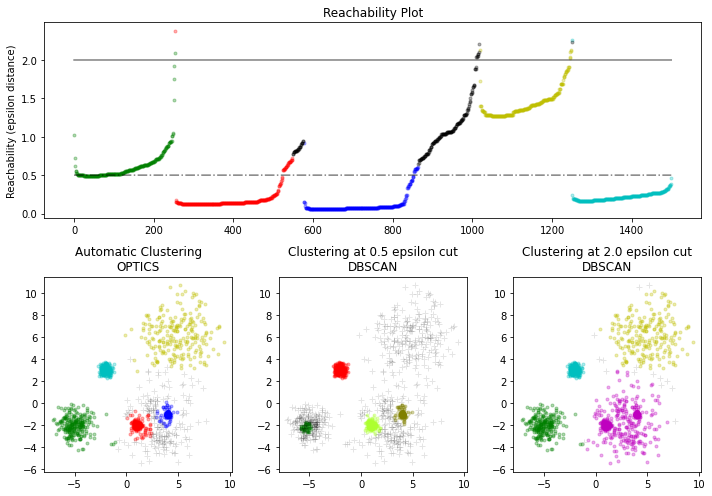

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Gerar dados de teste

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

# Clustering OPTICS
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Executar fit nos dados
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Alcance (distancia epsilon)')
ax1.set_title('Plot de Alcance')

# OPTICS clustering
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Clustering Automatico\nOPTICS')

# DBSCAN clustering com epsilon = 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering com 0.5 epsilon \nDBSCAN')

# DBSCAN clustering com epsilon = 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering com 2.0 epsilon \nDBSCAN')

plt.tight_layout()
plt.show()

In [ ]:
X

array([[-3.58875812, -1.67987423],
       [-4.21700961, -0.20728544],
       [-3.50595361, -2.7818223 ],
       ...,
       [ 5.64006386, 10.15835333],
       [ 3.18506804,  5.61519158],
       [ 2.57496851,  5.83880297]])

## MiniBatchKMeans
O MiniBatchKMeans é uma variante do algoritmo KMeans que usa minilotes para reduzir o tempo de cálculo, enquanto tenta otimizar a mesma função objetivo. Os minilotes são subconjuntos dos dados de entrada, amostrados aleatoriamente em cada iteração de treinamento. Esses minilotes reduzem drasticamente a quantidade de computação necessária para convergir para uma solução local. Em contraste com outros algoritmos que reduzem o tempo de convergência de k-médias, o minilote k-médias produz resultados que geralmente são apenas ligeiramente piores do que o algoritmo padrão.

O algoritmo itera entre duas etapas principais, semelhante ao vanilla k-means. Na primeira etapa, as amostras são retiradas aleatoriamente do conjunto de dados, para formar um minilote. Eles são então atribuídos ao centróide mais próximo. Na segunda etapa, os centróides são atualizados. Em contraste com k-means, isso é feito por amostra. Para cada amostra no minilote, o centróide atribuído é atualizado tomando a média de fluxo da amostra e todas as amostras anteriores atribuídas a esse centróide. Isso tem o efeito de diminuir a taxa de alteração de um centróide ao longo do tempo. Essas etapas são executadas até que a convergência ou um número predeterminado de iterações seja alcançado.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Mostrar barra de progresso
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# argumentos de linha de comando
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("Esse script nao recebeargumentos de input.")
    sys.exit(1)


# #############################################################################
# Algumas categorias(para nao fazer todas)
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# USe quiser fazer para todas as categories, descomenteabaixo
# categories = None

print("Carregado 20 dataset newsgroups:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documentos" % len(dataset.data))
print("%d categorias" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extraindo features do dataset de treino "
      "utilizando um vetorizador sparso")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("encerrando em %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("reducao de dimensionalidade com LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("encerrando em %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Variancia explicada do SVD: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering de dados sparsos %s" % km)
t0 = time()
km.fit(X)
print("Encerando em %0.3fs" % (time() - t0))
print()

print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Indice Rand ajustado: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Coeficiente de silueta: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top por cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

2020-09-22 20:55:35,100 INFO Downloading 20news dataset. This may take a few minutes.
2020-09-22 20:55:35,105 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Carregado 20 dataset newsgroups:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documentos
4 categorias

Extraindo features do dataset de treino utilizando um vetorizador sparso
encerrando em 0.817096s
n_samples: 3387, n_features: 10000

Clustering de dados sparsos MiniBatchKMeans(batch_size=1000, compute_label